# MODELO PARA DETERMINAR EL PRECIO DE UNA NOTA DE CRÉDITO

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import mstats

In [ ]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


### Pre-Procesamiento de los datos

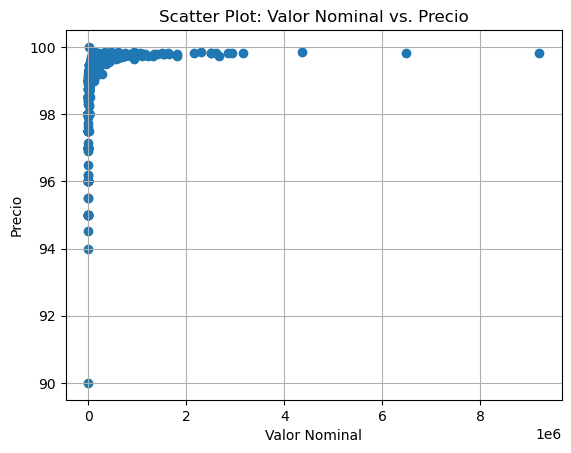

In [ ]:
#detectar si tiene outliers

import matplotlib.pyplot as plt

plt.scatter(df['Valor_Nominal'], df['Precio'])
plt.xlabel('Valor Nominal')
plt.ylabel('Precio')
plt.title('Scatter Plot: Valor Nominal vs. Precio')
plt.grid(True)  # Add grid lines for better readability (optional)
plt.show()

In [ ]:
import scipy.stats as stats

# Assuming your data is loaded into a pandas DataFrame named 'df'

# Calculate z-scores for 'Valor_Nominal'
def calculate_z_scores(data):
  """
  Calculates z-scores for a given data array.

  Args:
      data: A NumPy array of data points.

  Returns:
      A NumPy array containing the z-scores for each data point.
  """
  mean = np.mean(data)
  std = np.std(data)
  z_scores = (data - mean) / std
  return z_scores

z_scores_nominal = calculate_z_scores(df['Valor_Nominal'])

# Identify outliers based on z-score threshold (e.g., 3)
threshold = 3
outliers_zscore = df[np.abs(z_scores_nominal) > threshold]['Valor_Nominal']
print("Outliers based on z-score (absolute value > ", threshold, "):", outliers_zscore.to_numpy())  # Convert Series to NumPy array for printing

# Calculate IQR for 'Valor_Nominal'
q1_nominal = np.percentile(df['Valor_Nominal'], 25)
q3_nominal = np.percentile(df['Valor_Nominal'], 75)
iqr_nominal = q3_nominal - q1_nominal

# Calculate lower and upper bounds for IQR outlier detection
lower_bound = q1_nominal - 1.5 * iqr_nominal
upper_bound = q3_nominal + 1.5 * iqr_nominal

# Identify outliers based on IQR
outliers_iqr = df[(df['Valor_Nominal'] < lower_bound) | (df['Valor_Nominal'] > upper_bound)]['Valor_Nominal']
print("Outliers based on IQR (outside Q1-1.5IQR or Q3+1.5IQR):", outliers_iqr.to_numpy())

Outliers based on z-score (absolute value >  3 ): [1006849.73 1011014.02 1012241.8  1053998.75 1093319.83 1099228.84
 1120222.6  1150000.   1217987.68 1313240.81 1342435.28 1392813.23
 1500000.   1515305.03 1548605.78 1615164.42 1640951.25 1800000.
 1817752.18 2150312.49 2305963.   2500000.   2500000.   2601488.47
 2667148.18 2849362.96 2933448.12 3151937.62 4370035.88 6478677.33
 9208468.  ]
Outliers based on IQR (outside Q1-1.5IQR or Q3+1.5IQR): [  84769.81   85066.74   85195.29   85418.02   85611.1    85742.76
   85817.66   86131.19   86736.83   86988.65   87200.37   87357.66
   87470.48   88748.34   88883.54   89949.4    90000.     90370.44
   90768.3    90960.51   91000.     91272.24   91403.95   91676.37
   91746.07   91841.88   91858.28   92760.     92760.     93197.93
   93293.73   94323.19   94594.21   95000.     95272.88   95515.08
   95952.54   96547.     96676.04   96730.12   97128.1    97792.37
   98030.88   99289.63   99324.58  100000.    100000.    100000.
  100000.    1

In [ ]:
#Handling Outliers
df['Valor_Nominal'] = mstats.winsorize(df['Valor_Nominal'], limits=[0.05, 0.05])

# Feature Scaling
scaler = MinMaxScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

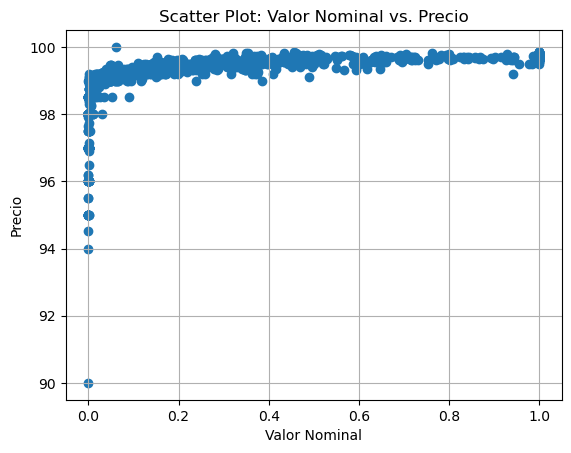

In [ ]:
plt.scatter(df['Valor_Nominal'], df['Precio'])
plt.xlabel('Valor Nominal')
plt.ylabel('Precio')
plt.title('Scatter Plot: Valor Nominal vs. Precio')
plt.grid(True)  # Add grid lines for better readability (optional)
plt.show()

## Regresión Lineal

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress

X = df[['Valor_Nominal']]
Y = df['Precio']

# KFold para Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas vacías para guardar las métricas de evaluación de cada fold
mse_scores = []
r2_scores = []
p_values = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Entrenar el Modelo de Regresión Lineal
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Hacer predicciones en el test set para este fold
    y_predicted = model.predict(X_test)

    # Calcular las métricas de evaluación
    mse = mean_squared_error(y_test, y_predicted)
    r2 = r2_score(y_test, y_predicted)
    slope, intercept, r_value, p_value, std_err = linregress(X_test.values.ravel(), y_test)

    # Guardar las métricas de evaluación
    mse_scores.append(mse)
    r2_scores.append(r2)
    p_values.append(p_value)

# Print average scores across all folds
print("Average Mean Squared Error:", np.mean(mse_scores))
print("Average R-squared:", np.mean(r2_scores))
print("Average P-value:", np.mean(p_values))


Average Mean Squared Error: 0.33814570362114516
Average R-squared: 0.22385932957158614
Average P-value: 2.2602754433126444e-28


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
final_model = LinearRegression()
final_model.fit(X_train, y_train)
y_predicted_final = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_predicted_final)
final_r2 = r2_score(y_test, y_predicted_final)
_, _, _, final_p_value, _ = linregress(X_test.values.ravel(), y_test)
print("Mean Squared Error on final test set:", final_mse)
print("R-squared on final test set:", final_r2)
print("P-value on final test set:", final_p_value)

Mean Squared Error on final test set: 0.22854746406775495
R-squared on final test set: 0.29383107610370907
P-value on final test set: 6.690030716482308e-45


### Predicciones

In [ ]:
new_data = [[1000000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [103.06111734]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
new_data = [[100000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.23784701]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
new_data = [[10000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.85551997]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
new_data = [[1000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.81728727]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


### Pre-Procesamiento de los datos 2

In [ ]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [ ]:
scaler = MinMaxScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

## Regresión lineal 2

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress

X = df[['Valor_Nominal']]
Y = df['Precio']

# KFold para Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas vacías para guardar las métricas de evaluación de cada fold
mse_scores = []
r2_scores = []
p_values = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Entrenar el Modelo de Regresión Lineal
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Hacer predicciones en el test set para este fold
    y_predicted = model.predict(X_test)

    # Calcular las métricas de evaluación
    mse = mean_squared_error(y_test, y_predicted)
    r2 = r2_score(y_test, y_predicted)
    slope, intercept, r_value, p_value, std_err = linregress(X_test.values.ravel(), y_test)

    # Guardar las métricas de evaluación
    mse_scores.append(mse)
    r2_scores.append(r2)
    p_values.append(p_value)

# Print average scores across all folds
print("Average Mean Squared Error:", np.mean(mse_scores))
print("Average R-squared:", np.mean(r2_scores))
print("Average P-value:", np.mean(p_values))

Average Mean Squared Error: 0.41731947309246487
Average R-squared: 0.036347211751598205
Average P-value: 4.867560227155702e-05


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
final_model = LinearRegression()
final_model.fit(X_train, y_train)
y_predicted_final = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_predicted_final)
final_r2 = r2_score(y_test, y_predicted_final)
_, _, _, final_p_value, _ = linregress(X_test.values.ravel(), y_test)
print("Mean Squared Error on final test set:", final_mse)
print("R-squared on final test set:", final_r2)
print("P-value on final test set:", final_p_value)

Mean Squared Error on final test set: 0.3009705381181918
R-squared on final test set: 0.07005732094055139
P-value on final test set: 3.277231916170298e-14


### Predicciones

In [ ]:
new_data = [[1000000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.40396013]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
new_data = [[100000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.99552105]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
new_data = [[10000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.95467714]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
new_data = [[10000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.95467714]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Regresión 3

In [ ]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [ ]:
from sklearn.preprocessing import StandardScaler

# Logarithmic transformation for 'Valor_Nominal'
df['Log_Valor_Nominal'] = np.log(df['Valor_Nominal'])

# Standardize both features
scaler = StandardScaler()
df['Log_Valor_Nominal'] = scaler.fit_transform(df[['Log_Valor_Nominal']])

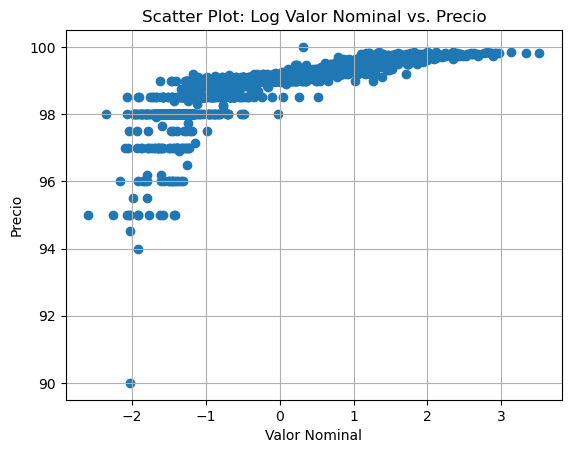

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df['Log_Valor_Nominal'], df['Precio'])
plt.xlabel('Valor Nominal')
plt.ylabel('Precio')
plt.title('Scatter Plot: Log Valor Nominal vs. Precio')
plt.grid(True)  # Add grid lines for better readability (optional)
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress

X = df[['Log_Valor_Nominal']]
Y = df['Precio']

# KFold para Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas vacías para guardar las métricas de evaluación de cada fold
mse_scores = []
r2_scores = []
p_values = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Entrenar el Modelo de Regresión Lineal
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Hacer predicciones en el test set para este fold
    y_predicted = model.predict(X_test)

    # Calcular las métricas de evaluación
    mse = mean_squared_error(y_test, y_predicted)
    r2 = r2_score(y_test, y_predicted)
    slope, intercept, r_value, p_value, std_err = linregress(X_test.values.ravel(), y_test)

    # Guardar las métricas de evaluación
    mse_scores.append(mse)
    r2_scores.append(r2)
    p_values.append(p_value)

# Print average scores across all folds
print("Average Mean Squared Error:", np.mean(mse_scores))
print("Average R-squared:", np.mean(r2_scores))
print("Average P-value:", np.mean(p_values))

Average Mean Squared Error: 0.19579801150713438
Average R-squared: 0.5511300369286488
Average P-value: 7.267581997480257e-86


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
final_model = LinearRegression()
final_model.fit(X_train, y_train)
y_predicted_final = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_predicted_final)
final_r2 = r2_score(y_test, y_predicted_final)
_, _, _, final_p_value, _ = linregress(X_test.values.ravel(), y_test)
print("Mean Squared Error on final test set:", final_mse)
print("R-squared on final test set:", final_r2)
print("P-value on final test set:", final_p_value)

Mean Squared Error on final test set: 0.122649998769133
R-squared on final test set: 0.6210344402640002
P-value on final test set: 2.2456600516742615e-123


In [ ]:
new_value = [[1000000]]
new_data = np.log(new_value)


# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [100.18114354]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
new_value = [[100000]]
new_data = np.log(new_value)


# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.59148111]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
new_value = [[10000]]
new_data = np.log(new_value)


# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.00181867]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


In [ ]:
new_value = [[1000]]
new_data = np.log(new_value)


# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.41215624]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


## Regresión 4

In [ ]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [ ]:
df['Log_Valor_Nominal'] = np.log(df['Valor_Nominal'])

# Standardize both features
scaler = MinMaxScaler()
df['Log_Valor_Nominal'] = scaler.fit_transform(df[['Log_Valor_Nominal']])

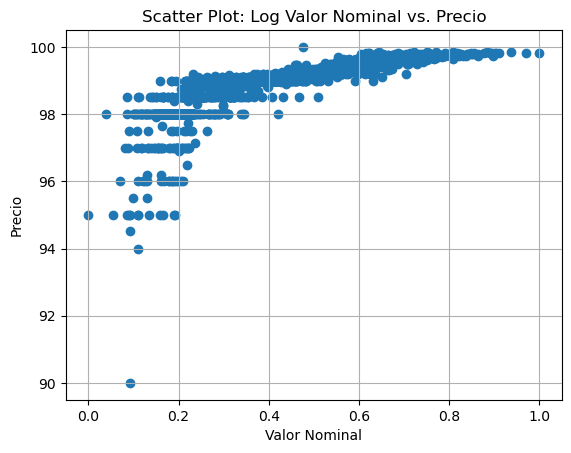

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(df['Log_Valor_Nominal'], df['Precio'])
plt.xlabel('Valor Nominal')
plt.ylabel('Precio')
plt.title('Scatter Plot: Log Valor Nominal vs. Precio')
plt.grid(True)  # Add grid lines for better readability (optional)
plt.show()

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress

X = df[['Log_Valor_Nominal']]
Y = df['Precio']

# KFold para Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas vacías para guardar las métricas de evaluación de cada fold
mse_scores = []
r2_scores = []
p_values = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Entrenar el Modelo de Regresión Lineal
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Hacer predicciones en el test set para este fold
    y_predicted = model.predict(X_test)

    # Calcular las métricas de evaluación
    mse = mean_squared_error(y_test, y_predicted)
    r2 = r2_score(y_test, y_predicted)
    slope, intercept, r_value, p_value, std_err = linregress(X_test.values.ravel(), y_test)

    # Guardar las métricas de evaluación
    mse_scores.append(mse)
    r2_scores.append(r2)
    p_values.append(p_value)

# Print average scores across all folds
print("Average Mean Squared Error:", np.mean(mse_scores))
print("Average R-squared:", np.mean(r2_scores))
print("Average P-value:", np.mean(p_values))

Average Mean Squared Error: 0.1957980115071343
Average R-squared: 0.5511300369286488
Average P-value: 7.267581997479429e-86


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
final_model = LinearRegression()
final_model.fit(X_train, y_train)
y_predicted_final = final_model.predict(X_test)
final_mse = mean_squared_error(y_test, y_predicted_final)
final_r2 = r2_score(y_test, y_predicted_final)
_, _, _, final_p_value, _ = linregress(X_test.values.ravel(), y_test)
print("Mean Squared Error on final test set:", final_mse)
print("R-squared on final test set:", final_r2)
print("P-value on final test set:", final_p_value)

Mean Squared Error on final test set: 0.12264999876913343
R-squared on final test set: 0.6210344402639989
P-value on final test set: 2.245660051676178e-123


## K Nearest Neighbor

### Sin Pre Procesamiento

In [2]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [5]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(1, 30),  
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)
# Use the best_model for prediction on new data

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 25}


In [6]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=25)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.06490777166145258
Mean Absolute Error: 0.1349512558139537
R-squared (R2): 0.7994471238014451


### Winsorization y MinMax

In [30]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [31]:
df['Valor_Nominal'] = mstats.winsorize(df['Valor_Nominal'], limits=[0.05, 0.05])

# Feature Scaling
scaler = MinMaxScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

In [34]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(55, 90),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)
# Use the best_model for prediction on new data

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 89}


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now you can use X_test and y_test to evaluate the model
y_pred = best_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae)

r2 = r2_score(y_test, y_pred)
print("R-squared (R2):", r2)


Mean Squared Error: 0.072766265604629
Mean Absolute Error: 0.14415058228387986
R-squared (R2): 0.7751658471137579


In [8]:
new_data = [[1000000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = best_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.72325033]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [9]:
new_data = [[100000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = best_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.53936556]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [10]:
new_data = [[10000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = best_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.06801457]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [11]:
new_data = [[1000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = best_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.44328543]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [12]:
new_data = [[60]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = best_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [97.44039735]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [13]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=151)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.072766265604629
Mean Absolute Error: 0.14415058228387986
R-squared (R2): 0.7751658471137579


In [15]:
new_data = [[1000000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.72325033]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [16]:
new_data = [[100000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.53936556]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [17]:
new_data = [[10000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.06801457]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [18]:
new_data = [[1000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.44328543]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [19]:
new_data = [[60]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [97.44039735]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


## Logaritmo

In [3]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [4]:
from sklearn.preprocessing import StandardScaler

# Logarithmic transformation for 'Valor_Nominal'
df['Log_Valor_Nominal'] = np.log(df['Valor_Nominal'])

# Standardize both features
scaler = StandardScaler()
df['Log_Valor_Nominal'] = scaler.fit_transform(df[['Log_Valor_Nominal']])

In [7]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(23, 60),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)
# Use the best_model for prediction on new data

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 25}


In [8]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=25)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.06490777166145258
Mean Absolute Error: 0.1349512558139537
R-squared (R2): 0.7994471238014451


In [10]:
new_value = [[1000000]]
new_data = np.log(new_value)


# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.3412]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


### MinMax

In [11]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [12]:
scaler = MinMaxScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

In [14]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(23, 60),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)
# Use the best_model for prediction on new data

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 25}


In [15]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=25)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.06490777166145258
Mean Absolute Error: 0.1349512558139537
R-squared (R2): 0.7994471238014451


In [17]:
new_data = [[1000000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.769464]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [18]:
new_data = [[100000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.530608]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [19]:
new_data = [[10000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.0868]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [20]:
new_data = [[1000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.558804]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [21]:
new_data = [[60]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.3412]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


### Winsorization

In [8]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [9]:
#Handling Outliers
df['Valor_Nominal'] = mstats.winsorize(df['Valor_Nominal'], limits=[0, 0.05])


In [12]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(1, 30),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)
# Use the best_model for prediction on new data

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 25}


In [13]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=25)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.06491455494869414
Mean Absolute Error: 0.1352441645796069
R-squared (R2): 0.7994261647123937


### Standard Scaler

In [15]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [16]:
from sklearn.preprocessing import StandardScaler
# Feature Scaling
scaler = StandardScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

In [17]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(1, 30),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)
# Use the best_model for prediction on new data

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 25}


In [18]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=25)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.06490777166145258
Mean Absolute Error: 0.1349512558139537
R-squared (R2): 0.7994471238014451


## KNN Valor nominal Menor a 100 mil

### Sin Pre-Procesamiento

In [3]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC_Menor100mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


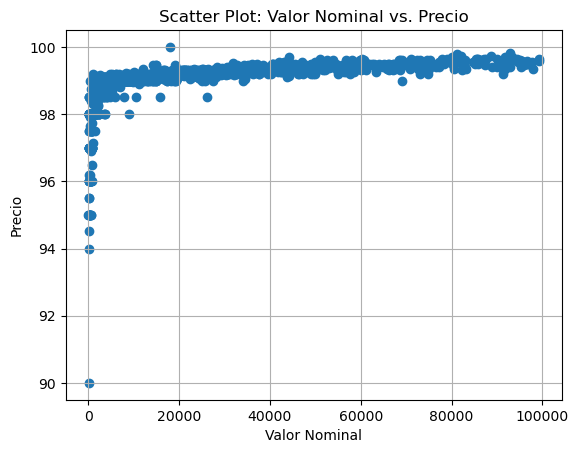

In [4]:
import matplotlib.pyplot as plt

plt.scatter(df['Valor_Nominal'], df['Precio'])
plt.xlabel('Valor Nominal')
plt.ylabel('Precio')
plt.title('Scatter Plot: Valor Nominal vs. Precio')
plt.grid(True)  # Add grid lines for better readability (optional)
plt.show()

In [7]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(1, 30),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)
# Use the best_model for prediction on new data

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 26}


In [8]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=26)

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.1120136497069845
Mean Absolute Error: 0.17210350445009517
R-squared (R2): 0.6493942813648692


#### Predicciones

In [81]:
new_data = [[90000]]

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.536004]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [86]:
new_data = [[50000]]

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.388]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [87]:
new_data = [[10000]]

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.0868]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [88]:
new_data = [[1000]]

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.558804]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [89]:
new_data = [[60]]

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.3412]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


### MinMax

In [10]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC_Menor100mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [11]:
# Feature Scaling
scaler = MinMaxScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

In [14]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(1, 30),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 26}


In [15]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=26)

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.1120136497069845
Mean Absolute Error: 0.17210350445009517
R-squared (R2): 0.6493942813648692


#### Predicciones

In [17]:
new_data = [[90000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.54038846]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [18]:
new_data = [[50000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.39038462]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [97]:
new_data = [[1000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.558804]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [98]:
new_data = [[60]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.3412]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


### StandardScaler

In [99]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC_Menor100mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [100]:
df.describe()

,Precio,Valor_Nominal
count,2419.000000,2419.000000
mean,98.892974,14906.554200
std,0.649364,20446.730941
min,90.000000,60.490000
25%,99.000000,1769.900000
50%,99.020000,5966.240000
75%,99.200000,18806.705000
max,100.000000,99324.580000


In [101]:
from sklearn.preprocessing import StandardScaler
# Feature Scaling
scaler = StandardScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

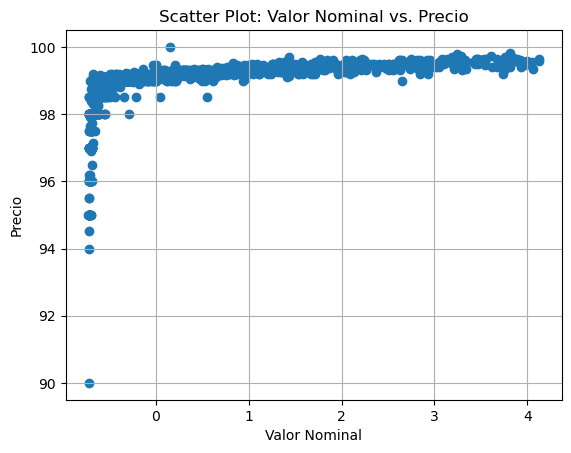

In [102]:
import matplotlib.pyplot as plt

plt.scatter(df['Valor_Nominal'], df['Precio'])
plt.xlabel('Valor Nominal')
plt.ylabel('Precio')
plt.title('Scatter Plot: Valor Nominal vs. Precio')
plt.grid(True)  # Add grid lines for better readability (optional)
plt.show()

In [103]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(1, 50, 2),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 25}


In [104]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=25)

In [105]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.11053460088076048
Mean Absolute Error: 0.17142885123966958
R-squared (R2): 0.6540237437381712


#### Predicciones

In [106]:
new_data = [[90000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.536004]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [107]:
new_data = [[10000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.0868]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [108]:
new_data = [[1000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.558804]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [109]:
new_data = [[6000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.021204]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


### Winsorization

In [140]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC_Menor100mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [141]:
#Handling Outliers
df['Valor_Nominal'] = mstats.winsorize(df['Valor_Nominal'], limits=[0.001, 0.05])

# Feature Scaling
scaler = MinMaxScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

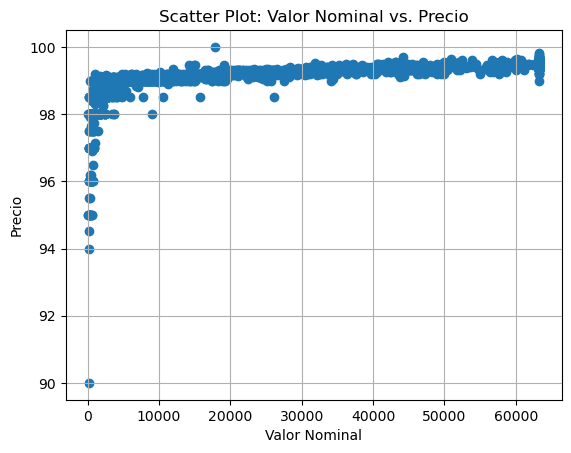

In [142]:
import matplotlib.pyplot as plt

plt.scatter(df['Valor_Nominal'], df['Precio'])
plt.xlabel('Valor Nominal')
plt.ylabel('Precio')
plt.title('Scatter Plot: Valor Nominal vs. Precio')
plt.grid(True)  # Add grid lines for better readability (optional)
plt.show()

In [143]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(1, 50, 2),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 29}


In [144]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=29)

In [145]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.1112556344142402
Mean Absolute Error: 0.17285533627814087
R-squared (R2): 0.6517668894991835


In [65]:
new_data = [[90000]]

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.53503256]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [67]:
new_data = [[1000]]

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.45279302]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [68]:
new_data = [[60]]

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.80302326]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


### Logaritmo

In [159]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC_Menor100mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [160]:
from sklearn.preprocessing import StandardScaler

# Logarithmic transformation for 'Valor_Nominal'
df['Log_Valor_Nominal'] = np.log(df['Valor_Nominal'])

# Standardize both features
scaler = StandardScaler()
df['Log_Valor_Nominal'] = scaler.fit_transform(df[['Log_Valor_Nominal']])

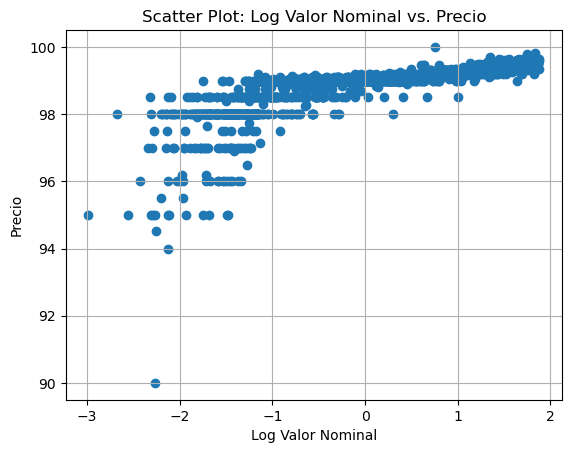

In [161]:
import matplotlib.pyplot as plt

plt.scatter(df['Log_Valor_Nominal'], df['Precio'])
plt.xlabel('Log Valor Nominal')
plt.ylabel('Precio')
plt.title('Scatter Plot: Log Valor Nominal vs. Precio')
plt.grid(True)  # Add grid lines for better readability (optional)
plt.show()

In [163]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Log_Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(1, 50, 2),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 35}


In [135]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=35)

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.11163355021953163
Mean Absolute Error: 0.17206478158205427
R-squared (R2): 0.650584002923803


In [137]:
new_value = [[90000]]
new_data = np.log(new_value)


# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.54773143]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [138]:
new_value = [[1000]]
new_data = np.log(new_value)


# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.52771714]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [139]:
new_value = [[60]]
new_data = np.log(new_value)


# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_data)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.64371429]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


## KNN Valor Nominal Menor a 50Mil USD

### Sin Pre-Procesamiento

In [14]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC_Menor50mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [23]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(1, 30),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 26}


In [17]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=26)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.10869218277109242
Mean Absolute Error: 0.17789538461538476
R-squared (R2): 0.6749575722651991


#### Predicciones

In [19]:
new_value = [[40000]]


# Make prediction using the model
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.3575]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [20]:
new_value = [[10000]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.08346154]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [21]:
new_value = [[1000]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.57577308]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [22]:
new_value = [[60]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.42423077]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


### MinMax Scaler

In [24]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC_Menor50mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [25]:
# Feature Scaling
scaler = MinMaxScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

In [26]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(1, 30),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 26}


In [27]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=26)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.10869218277109242
Mean Absolute Error: 0.17789538461538476
R-squared (R2): 0.6749575722651991


#### Predicciones

In [29]:
new_value = [[40000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.3575]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [30]:
new_value = [[60]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.42423077]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


### Standard Scaler

In [31]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC_Menor50mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [32]:
from sklearn.preprocessing import StandardScaler
# Feature Scaling
scaler = StandardScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

In [35]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(1, 30),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 26}


In [36]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=26)

In [37]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.10869218277109242
Mean Absolute Error: 0.17789538461538476
R-squared (R2): 0.6749575722651991


#### Predicciones

In [38]:
new_value = [[40000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.3575]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [39]:
new_value = [[60]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.42423077]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


### Winsorization

In [50]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC_Menor50mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [51]:
#Handling Outliers
df['Valor_Nominal'] = mstats.winsorize(df['Valor_Nominal'], limits=[0, 0.05])


In [52]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(1, 30),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 26}


In [53]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=26)

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.10870698999172267
Mean Absolute Error: 0.1778110544511669
R-squared (R2): 0.6749132914823595


#### Predicciones

In [55]:
new_value = [[40000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.34211538]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [56]:
new_value = [[60]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.42423077]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


### Logaritmo

In [85]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC_Menor50mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [86]:
from sklearn.preprocessing import StandardScaler

# Logarithmic transformation for 'Valor_Nominal'
df['Log_Valor_Nominal'] = np.log(df['Valor_Nominal'])


In [87]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RepeatedKFold
from sklearn.neighbors import KNeighborsRegressor

# Assuming your data is loaded into DataFrames 'X' (features) and 'y' (target)
X = df[['Log_Valor_Nominal']]  # Load your feature data
y = df['Precio'] # Load your target data

# Define the parameter grid for grid search
param_grid = {
    'n_neighbors': range(25, 60),  # Adjust range as needed (odd numbers for KNN)
    'metric': ['minkowski', 'euclidean', 'manhattan']  # Different distance metrics
}

# Define the KNN model
knn = KNeighborsRegressor()

# Set up Repeated Stratified K-Fold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Define the GridSearchCV object
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=cv, scoring='neg_mean_squared_error')  # Minimize mean squared error

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Print the best parameters and potentially evaluate the model on unseen data

print("Best KNN parameters:", best_params)

Best KNN parameters: {'metric': 'minkowski', 'n_neighbors': 35}


In [88]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

KNeighborsRegressor(n_neighbors=35)

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.11126443042658132
Mean Absolute Error: 0.17940090529695046
R-squared (R2): 0.6672653022108193


#### Predicciones

In [90]:
new_value = [[40000]]
new_data = np.log(new_value)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.35614286]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [91]:
new_value = [[10000]]
new_data = np.log(new_value)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.07771429]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [93]:
new_value = [[1000]]
new_data = np.log(new_value)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.52771714]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


In [94]:
new_value = [[60]]
new_data = np.log(new_value)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.64371429]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


## Regresion Lineal Valor Nominal menor a 100mil

In [156]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC_Menor100mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [157]:
from sklearn.preprocessing import StandardScaler

# Logarithmic transformation for 'Valor_Nominal'
df['Log_Valor_Nominal'] = np.log(df['Valor_Nominal'])

# Standardize both features
scaler = StandardScaler()
df['Log_Valor_Nominal'] = scaler.fit_transform(df[['Log_Valor_Nominal']])



In [158]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import linregress

X = df[['Log_Valor_Nominal']]
Y = df['Precio']

# KFold para Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Listas vacías para guardar las métricas de evaluación de cada fold
mse_scores = []
r2_scores = []
p_values = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Entrenar el Modelo de Regresión Lineal
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Hacer predicciones en el test set para este fold
    y_predicted = model.predict(X_test)

    # Calcular las métricas de evaluación
    mse = mean_squared_error(y_test, y_predicted)
    r2 = r2_score(y_test, y_predicted)
    slope, intercept, r_value, p_value, std_err = linregress(X_test.values.ravel(), y_test)

    # Guardar las métricas de evaluación
    mse_scores.append(mse)
    r2_scores.append(r2)
    p_values.append(p_value)

# Print average scores across all folds
print("Average Mean Squared Error:", np.mean(mse_scores))
print("Average R-squared:", np.mean(r2_scores))
print("Average P-value:", np.mean(p_values))


Average Mean Squared Error: 0.2086010798183564
Average R-squared: 0.502629928674595
Average P-value: 1.1786253636739974e-61


## Support Vector Machine

### Sin Pre-Procesamiento

In [4]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [5]:
from sklearn.svm import SVR
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error



X = df[['Valor_Nominal']]  # Feature variable
y = df['Precio']  # Target variable

# Define the parameter grid for grid search
param_grid = {
    'C': [0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512],  # Regularization parameter
}

# Define the SVR model
svr = SVR(kernel="rbf")

# Set up RepeatedKFold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv)

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)

# Print the best parameters
print("Best SVM parameters:", best_params)


Mean Squared Error: 0.3050186064038913
Best SVM parameters: {'C': 128}


In [6]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

SVR(C=128)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.19122034167373916
Mean Absolute Error: 0.21112380945476283
R-squared (R2): 0.409164903852123


#### Estimaciones

In [8]:
new_value = [[9000000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.30208456]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [9]:
new_value = [[1000000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.71397722]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [10]:
new_value = [[100000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.58284794]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [11]:
new_value = [[10000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.02557338]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [12]:
new_value = [[1000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.87830687]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [13]:
new_value = [[60]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.86153614]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


### MinMax

In [14]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [15]:
# Feature Scaling
scaler = MinMaxScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

In [16]:
from sklearn.svm import SVR
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error



X = df[['Valor_Nominal']]  # Feature variable
y = df['Precio']  # Target variable

# Define the parameter grid for grid search
param_grid = {
    'C': [0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512],  # Regularization parameter
}

# Define the SVR model
svr = SVR(kernel="rbf")

# Set up RepeatedKFold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv)

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)

# Print the best parameters
print("Best SVM parameters:", best_params)

Mean Squared Error: 0.30501860640388617
Best SVM parameters: {'C': 128}


In [17]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

SVR(C=128)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.19122034167375015
Mean Absolute Error: 0.2111238094548637
R-squared (R2): 0.40916490385208903


#### Estimaciones

In [19]:
new_value = [[9000000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.30208456]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [20]:
new_value = [[1000000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.71397722]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [21]:
new_value = [[100000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.58284794]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [22]:
new_value = [[1000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.87830687]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [23]:
new_value = [[60]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.86153614]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


### Standard Scaler

In [24]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [25]:
from sklearn.preprocessing import StandardScaler
# Feature Scaling
scaler = StandardScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

In [26]:
from sklearn.svm import SVR
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error



X = df[['Valor_Nominal']]  # Feature variable
y = df['Precio']  # Target variable

# Define the parameter grid for grid search
param_grid = {
    'C': [0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512],  # Regularization parameter
}

# Define the SVR model
svr = SVR(kernel="rbf")

# Set up RepeatedKFold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv)

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)

# Print the best parameters
print("Best SVM parameters:", best_params)

Mean Squared Error: 0.3050186064038789
Best SVM parameters: {'C': 128}


In [27]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

SVR(C=128)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.19122034167372678
Mean Absolute Error: 0.2111238094547716
R-squared (R2): 0.4091649038521612


#### Estimaciones

In [29]:
new_value = [[9000000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.30208456]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [30]:
new_value = [[1000000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.71397722]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [31]:
new_value = [[100000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.58284794]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [32]:
new_value = [[60]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.86153614]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


### Winsorization

In [2]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [3]:
#Handling Outliers
df['Valor_Nominal'] = mstats.winsorize(df['Valor_Nominal'], limits=[0, 0.05])

In [4]:
from sklearn.svm import SVR
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error



X = df[['Valor_Nominal']]  # Feature variable
y = df['Precio']  # Target variable

# Define the parameter grid for grid search
param_grid = {
    'C': [4096, 8192],  # Regularization parameter
}

# Define the SVR model
svr = SVR(kernel="rbf")

# Set up RepeatedKFold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv)

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)

# Print the best parameters
print("Best SVM parameters:", best_params)

Mean Squared Error: 0.23069747356056275
Best SVM parameters: {'C': 8192}


In [5]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

SVR(C=8192)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.13402824590956175
Mean Absolute Error: 0.19564171814353692
R-squared (R2): 0.5858777844167904


In [7]:
new_value = [[200000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.65238488]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [8]:
new_value = [[100000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.58017461]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [9]:
new_value = [[10000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.17615549]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [10]:
new_value = [[1000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.62371122]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


In [11]:
new_value = [[60]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.49314235]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but SVR was fitted with feature names
  warnings.warn(


### Logaritmo

In [12]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [13]:
from sklearn.preprocessing import StandardScaler

# Logarithmic transformation for 'Valor_Nominal'
df['Log_Valor_Nominal'] = np.log(df['Valor_Nominal'])


In [14]:
from sklearn.svm import SVR
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error



X = df[['Valor_Nominal']]  # Feature variable
y = df['Precio']  # Target variable

# Define the parameter grid for grid search
param_grid = {
    'C': [0.25, 0.5, 1, 2, 4, 8, 16, 32, 64, 128, 256, 512],  # Regularization parameter
}

# Define the SVR model
svr = SVR(kernel="rbf")

# Set up RepeatedKFold cross-validation
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, scoring='neg_mean_squared_error', cv=cv)

# Train the model with grid search
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)

# Print the best parameters
print("Best SVM parameters:", best_params)

Mean Squared Error: 0.3050186064038913
Best SVM parameters: {'C': 128}


## Random Forest

## Sin Pre-Procesamiento

In [3]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10, 15],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)


Mean Squared Error: 0.09357499475401491
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: -0.12135959390250733


In [16]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=200)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.05504515674912399
Mean Absolute Error: 0.1276737669609032
R-squared (R2): 0.8299207594983078


In [18]:
new_value = [[9000000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.77489423]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [19]:
new_value = [[1000000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.77212726]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [20]:
new_value = [[500000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.73064036]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [21]:
new_value = [[100000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.53180156]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [22]:
new_value = [[10000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.07260576]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [23]:
new_value = [[1000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.57884747]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [24]:
new_value = [[60]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.16589125]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Winsorization

In [25]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [26]:
#Handling Outliers
df['Valor_Nominal'] = mstats.winsorize(df['Valor_Nominal'], limits=[0, 0.05])

In [30]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Mean Squared Error: 0.09247695333247909
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: -0.12106349402807122


In [31]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=50)

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.05616414568067535
Mean Absolute Error: 0.12864936034526
R-squared (R2): 0.8264632929590544


#### Estimaciones

In [33]:
new_value = [[9000000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.73558039]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [34]:
new_value = [[1000000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.73558039]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [35]:
new_value = [[100000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.53781771]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [36]:
new_value = [[10000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.0685541]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [37]:
new_value = [[1000]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.6154002]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [38]:
new_value = [[60]]


# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.08211087]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### MinMax

In [53]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [54]:
# Feature Scaling
scaler = MinMaxScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

In [55]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [25, 50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Mean Squared Error: 0.09374608033371694
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: -0.12040829807456724


In [43]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10)

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.05631714468667823
Mean Absolute Error: 0.1274063694787292
R-squared (R2): 0.8259905546424559


In [46]:
new_value = [[9000000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.7754921]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [47]:
new_value = [[1000000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.77479915]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [48]:
new_value = [[100000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.53332423]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [49]:
new_value = [[10000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.07469679]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [51]:
new_value = [[1000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.60687134]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [52]:
new_value = [[60]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.23451791]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Standard Scaler

In [56]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [57]:
from sklearn.preprocessing import StandardScaler

# Feature Scaling
scaler = StandardScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

In [58]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Mean Squared Error: 0.094818164924832
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: -0.12123539575145953


In [59]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10)

In [60]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.055186305753184964
Mean Absolute Error: 0.12735452269029757
R-squared (R2): 0.8294846354716714


#### Estimaciones

In [61]:
new_value = [[9000000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.7749093]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [62]:
new_value = [[1000000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.77206629]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [63]:
new_value = [[100000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.52849964]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [64]:
new_value = [[10000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.0708068]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [65]:
new_value = [[1000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.55160685]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [66]:
new_value = [[60]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.15172474]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Logaritmo

In [67]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [68]:
from sklearn.preprocessing import StandardScaler

# Logarithmic transformation for 'Valor_Nominal'
df['Log_Valor_Nominal'] = np.log(df['Valor_Nominal'])


In [78]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Log_Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Mean Squared Error: 0.09520918367852302
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: -0.12061429504720164


In [79]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=50)

In [80]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.0558822507953426
Mean Absolute Error: 0.12805170168988195
R-squared (R2): 0.8273342954382956


#### Estimaciones

In [72]:
new_value = [[9000000]]
new_data = np.log(new_value)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.77465685]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [73]:
new_value = [[1000000]]
new_data = np.log(new_value)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.77133573]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [74]:
new_value = [[100000]]
new_data = np.log(new_value)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.53383405]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [75]:
new_value = [[10000]]
new_data = np.log(new_value)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.07116673]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [76]:
new_value = [[1000]]
new_data = np.log(new_value)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.57339869]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [77]:
new_value = [[60]]
new_data = np.log(new_value)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.1333643]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Random Forest Valor Nominal menor a 100 Mil USD

### Sin Pre-Procesamiento

In [12]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC_Menor100mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Mean Squared Error: 0.10592767225698017
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: -0.13847809924045237


In [21]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=200)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.09878451128090994
Mean Absolute Error: 0.1650237469037561
R-squared (R2): 0.6908018383628828


#### Estimaciones

In [23]:
new_value = [[100000]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.5380648]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [24]:
new_value = [[10000]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.07175931]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [25]:
new_value = [[1000]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.5906389]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [26]:
new_value = [[60]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.05758762]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Winsorization

In [27]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC_Menor100mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [28]:
#Handling Outliers
df['Valor_Nominal'] = mstats.winsorize(df['Valor_Nominal'], limits=[0, 0.05])

In [38]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Mean Squared Error: 0.10721939588450523
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: -0.1384049114323002


In [39]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10)

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.09918666639166303
Mean Absolute Error: 0.16525198561738
R-squared (R2): 0.6895430821132899


#### Estimaciones

In [41]:
new_value = [[90000]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.49285966]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [42]:
new_value = [[10000]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.07517821]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [43]:
new_value = [[1000]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.59683438]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [44]:
new_value = [[60]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.10031995]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### MinMax

In [46]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC_Menor100mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [47]:
# Feature Scaling
scaler = MinMaxScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

In [48]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Mean Squared Error: 0.10747431515511029
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: -0.13879579535614484


In [49]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=50)

In [50]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.10169827282498257
Mean Absolute Error: 0.1662780142288324
R-squared (R2): 0.681681686820965


#### Estimaciones

In [51]:
new_value = [[100000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.537315]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [53]:
new_value = [[10000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.07425788]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [54]:
new_value = [[1000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.62801836]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [55]:
new_value = [[60]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.00597197]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Standard Scaler

In [57]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC_Menor100mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [58]:
from sklearn.preprocessing import StandardScaler

# Feature Scaling
scaler = StandardScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Mean Squared Error: 0.10616715651310868
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: -0.13897874681349331


In [60]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=200)

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.09907383249868185
Mean Absolute Error: 0.16495718600199458
R-squared (R2): 0.6898962552153052


In [62]:
new_value = [[100000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.54802666]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [63]:
new_value = [[10000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.0716908]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [64]:
new_value = [[1000]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.60507563]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [65]:
new_value = [[60]]

# Apply the same scaling transformation as used during training
scaled_new_data = scaler.transform(new_value)

# Make prediction using the model 
predicted_price = final_model.predict(scaled_new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.10084447]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### Logaritmo

In [2]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC_Menor100mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [3]:
from sklearn.preprocessing import StandardScaler

# Logarithmic transformation for 'Valor_Nominal'
df['Log_Valor_Nominal'] = np.log(df['Valor_Nominal'])


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Log_Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Mean Squared Error: 0.10716710734780524
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 50}
Best Score: -0.13862089672165556


In [5]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=50)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.09723993186375299
Mean Absolute Error: 0.16374462339750862
R-squared (R2): 0.6956364132379802


In [7]:
new_value = [[100000]]
new_data = np.log(new_value)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.53730016]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [8]:
new_value = [[10000]]
new_data = np.log(new_value)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.07602284]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [9]:
new_value = [[1000]]
new_data = np.log(new_value)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.56724311]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [10]:
new_value = [[60]]
new_data = np.log(new_value)

# Make prediction using the model (assuming 'final_model' is your trained model)
predicted_price = final_model.predict(new_data)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.22966411]


C:\Users\Metrovalores\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Random Forest Valor Nominal Menor a 50 mil USD

### Sin Pre-Procesamiento

In [2]:
df = pd.read_excel(r"C:\Users\User\Documents\Precio_VN_NC_Menor50mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Mean Squared Error: 0.1147957609529411
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 400}
Best Score: -0.14943356843970904


In [5]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=400)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.0896005924903773
Mean Absolute Error: 0.16638209651336022
R-squared (R2): 0.7320507016508775


In [7]:
new_value = [[45000]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.35803128]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [8]:
new_value = [[10000]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [99.07105158]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [9]:
new_value = [[1000]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [98.57757142]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


In [10]:
new_value = [[60]]


# Make prediction using the model 
predicted_price = final_model.predict(new_value)

print("Predicted price for the new data point:", predicted_price)

Predicted price for the new data point: [96.08571008]


C:\Users\User\anaconda3\lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


### MinMax

In [2]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC_Menor50mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [3]:
# Feature Scaling
scaler = MinMaxScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Mean Squared Error: 0.11430994221633908
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
Best Score: -0.14888296287275857


In [6]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10)

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.08773434864748363
Mean Absolute Error: 0.1655176774002211
R-squared (R2): 0.7376316773381245


### Standard Scaler

In [8]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC_Menor50mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [9]:
from sklearn.preprocessing import StandardScaler

# Feature Scaling
scaler = StandardScaler()
df['Valor_Nominal'] = scaler.fit_transform(df[['Valor_Nominal']])

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Mean Squared Error: 0.11348509722399429
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: -0.14954513920215126


In [11]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=200)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.08978529617346777
Mean Absolute Error: 0.16632352731813074
R-squared (R2): 0.7314983479117891


### Winsorization

In [13]:
df = pd.read_excel(r"C:\Users\Metrovalores\Documents\Precio_VN_NC_Menor50mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [14]:
#Handling Outliers
df['Valor_Nominal'] = mstats.winsorize(df['Valor_Nominal'], limits=[0, 0.025])

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Mean Squared Error: 0.11453863265443968
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: -0.14948956697135624


In [16]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=200)

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.09099260789161868
Mean Absolute Error: 0.16783440811479292
R-squared (R2): 0.727887899378182


### Logaritmo

In [2]:
df = pd.read_excel(r"C:\Users\Metrovalores\Downloads\Precio_VN_NC_Menor50mil.xlsx")

df.head()

,Precio,Valor_Nominal
0,95.0,60.49
1,98.0,97.02
2,95.0,114.92
3,96.0,141.14
4,97.0,160.40


In [3]:
from sklearn.preprocessing import StandardScaler

# Logarithmic transformation for 'Valor_Nominal'
df['Log_Valor_Nominal'] = np.log(df['Valor_Nominal'])

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RepeatedKFold, GridSearchCV
from sklearn.metrics import mean_squared_error


# Separate feature and target variable
X = df[["Log_Valor_Nominal"]]
y = df["Precio"]

# Define the Random Forest model
rf = RandomForestRegressor()

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
}

# Define the RepeatedKFold cross-validation strategy
cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=42)

# Create GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=cv, scoring='neg_mean_squared_error')

# Fit the model and tune hyperparameters
grid_search.fit(X, y)

# Get the best model and its parameters
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions
y_pred = best_model.predict(X)

# Calculate Mean Squared Error
mse = mean_squared_error(y, y_pred)
print("Mean Squared Error:", mse)


# Print the best hyperparameters and score
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Mean Squared Error: 0.11499591811607908
Best Hyperparameters: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 200}
Best Score: -0.1495831345091141


In [5]:
final_model = grid_search.best_estimator_

final_model.fit(X, y)

RandomForestRegressor(max_depth=5, min_samples_split=10, n_estimators=200)

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_pred = final_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)


print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared (R2):", r2)

Mean Squared Error: 0.08970693471051383
Mean Absolute Error: 0.1662517908696356
R-squared (R2): 0.7317326867530012
